In [8]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\Users\Mochi\AppData\Local\Programs\Python\Python310\Lib\site-packages')
import quads
import numpy as np
import random

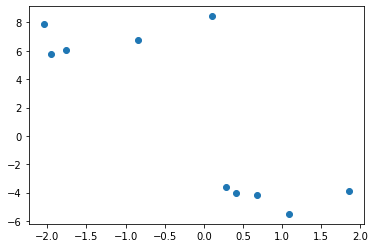

In [10]:
X, y = make_blobs(n_samples=10, centers=2, n_features=2,random_state=100)
plt.scatter(X[:,0], X[:,1])

In [11]:
class Node:
    def __init__(self, node_id, dataset):
        """
        dataset : np.array
        """
        self.node_id = node_id
        self.dataset = dataset
        self.parent = None
        self.left = None
        self.right = None
    
    def __repr__(self):
        return 'Node {}: {}'.format(str(self.node_id), str(self.dataset))

       
    def add_left(self, left_children, current_id):
        left = Node(current_id+1, left_children)
        left.parent = self
        self.left = left
        
    def add_right(self, right_children, current_id):
        right = Node(current_id+2, right_children)
        right.parent = self
        self.right = right

In [34]:
class Fair_Split_Tree:
    """A node contained in a fair split tree.

    """

    def __init__(self, dataset, k):
        """
        dataset : np.array
        """
        self.dataset = dataset
        self.root = Node(0, dataset)
        self.nodes = []
        self.k = k
        
        self.nodes.append(self.root)
      
    def pick_random(self, dataset):
        same = True
        while same:
            points = np.array(random.choices(dataset, k=2))
            if not (points[0] == points[1]).all():
                same = False
        return points
    def compute_plane(self, points):
        """
            v = direction vector
            w = unit vector
            mid = midpoint
        """
        
        v = points[0]-points[1]
        w = v / np.linalg.norm(v)
        mid = np.sum(points, axis=0)/2
        return w, mid
    
    def split_tree(self, node):
        points = self.pick_random(node.dataset)
        w, mid = self.compute_plane(points)
        left = []
        right = []
        for i in range(node.dataset.shape[0]):
            x = node.dataset[i]
            x = x - mid
            if np.dot(w,x) > 0:
                left.append(node.dataset[i])
            elif np.dot(w,x) < 0:
                right.append(node.dataset[i])
        if len(left)+len(right) != node.dataset.shape[0]:
            print("error")
        
        #plots out each split
        print('Node', len(self.nodes), 'and', len(self.nodes)+1)
        plt.scatter(np.array(left)[:,0], np.array(left)[:,1], c='blue');
        plt.scatter(np.array(right)[:,0], np.array(right)[:,1], c='red');
        plt.show()
        
        
        node.add_left(np.array(left), len(self.nodes)-1)
        node.add_right(np.array(right), len(self.nodes)-1)
        self.nodes.append(node.left)
        self.nodes.append(node.right)
        
        
        if len(left) > self.k:
            self.split_tree(node.left)
        if len(right) > self.k:
            self.split_tree(node.right)

    def build_tree(self):       
        if self.dataset.shape[0] == 1:
            return self
        else:
            node = self.root
            self.split_tree(node)
            return self
         

In [51]:
def Distance(p1, p2):
    """
    Computes the distance between p1 and p2 without square-rooting the sum. 
    
    Parameters
    ----------
    
    p1 : 
        
    Returns
    ----------
    
    diam : int
        The diameter of the given node
        
    """
    d = np.square(p1-p2)
    d = sum(d)
    #d = np.linalg.norm(p1-p2)
    return d

def Compute_Diam(node):
    """
    Computes the diameter of the node. 
    If the node contains 0 or 1 point, its diameter will be 0.
    
    Parameters
    ----------
    
    node : QuadNode
        The node to compute diameter
        
    Returns
    ----------
    
    diam : int
        The diameter of the given node
        
    """
    if len(node.dataset) > 1:
        max_D = 0
        for i in range(len(node.dataset)):
            for j in range(i + 1, len(node.dataset)):
                max_D = max(max_D, Distance(node.dataset[i],node.dataset[j]))
        return max_D
                    
    else:
        return 0 

def flatten(S):
    """
    Flattens a nested list S.
    Referenced from https://stackoverflow.com/questions/12472338/flattening-a-list-recursively
    
    Parameters
    ----------
    
    S : list
        A list to be flattened
        
    Returns
    ----------
    
    new_S : list
        Flattened new list
        
    """
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

def Node_Distance(node_u, node_v):
    """
    Computes the minimum distance between a data point in node_u and a data point in node_v.
    
    Parameters
    ----------
    
    node_u : QuadNode
        A node of a tree
        
    node_v : QuadNode
        A node of a tree
        
    Returns
    ----------
    
    minD : float
        Minimum distance between node_u and node_v
    """
    if node_u == node_v:
        return 0
    points_u = node_u.dataset
    points_v = node_v.dataset
    min_D = sys.float_info.max
    for p_u in range(points_u.shape[0]):
        u = points_u[p_u]
        for p_v in range(points_v.shape[0]):
            v = points_v[p_v]
            min_D = min(min_D, np.linalg.norm(u-v))
    return min_D

def WSPD(node_u, node_v, epsilon):
    """
    Computes all WSPD pairs of a tree starting from node_u and node_v.
    To compute all WSPD pairs of a tree, set node_u = node_v = tree._root.
    Each WSPD pair is in the format of (Node_A, Node_B).
    
    Parameters
    ----------
    
    node_u : QuadNode
        A node of a tree
        
    node_v : QuadNode
        A node of a tree
    
    epsilon : int
        The separator factor of WSPD pairs.
        
    Returns
    ----------
    
    pairs : list
        A list of WSPD pairs of
    """
    pairs = []
    diam_u = Compute_Diam(node_u)
    diam_v = Compute_Diam(node_v)
    if node_u == node_v and node_u.dataset.shape[0] <=1:
        return []
    if diam_u < diam_v:
        node_u, node_v = node_v, node_u
        diam_u, diam_v = diam_v, diam_u
    if diam_u <= epsilon * Node_Distance(node_u, node_v):
        return (node_u, node_v)
    
    if node_u.left is not None and node_u.left.dataset.shape[0] > 0:
        pairs.append(WSPD(node_u.left, node_v, epsilon))
    if node_u.right is not None and node_u.right.dataset.shape[0] > 0:
        pairs.append(WSPD(node_u.right, node_v, epsilon))

        
    pairs =  flatten(pairs)
    pairs = list(set(pairs))
    return pairs

In [27]:
def make_clusters(no_clusters_per_feature, cluster_size, return_means=False):
    no_features = len(no_clusters_per_feature)
    output = np.zeros((np.prod(no_clusters_per_feature)*cluster_size, no_features))
    # generate real features
    feature_centres = []
    for cluster_in_feature in no_clusters_per_feature:
        feature_centres.append([np.mean([i/cluster_in_feature, (i+1)/cluster_in_feature]) for i in range(cluster_in_feature)])
    means = []
    for x_vals in feature_centres:
        if len(means) == 0:
            for x in x_vals:
                means.append([x])
        else:
            cur_len = len(means)
            means = means * len(x_vals)
            for index, x in enumerate(x_vals):
                for i in range(cur_len * index, cur_len * index + cur_len):
                    means[i] = means[i] + [x]

    std_1 = [1/(10  * no_cluster) for no_cluster in no_clusters_per_feature]

    samples_1 = None
    for index, mean in enumerate(means):
        # generate samples
        cluster = np.random.normal(mean, std_1, size=[cluster_size, no_features])
        if samples_1 is None:
            samples_1 = cluster
        else:
            samples_1 = np.vstack((samples_1, cluster))


    if return_means:
        return samples_1, np.array(means)
    return samples_1


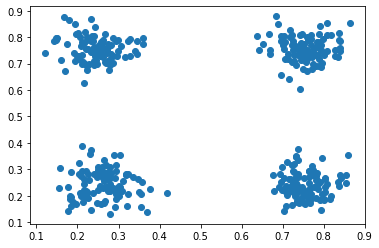

In [55]:
data = make_clusters([2,2], 100)
data.shape
plt.scatter(data[:,0], data[:,1]);

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
len(kmeans.labels_)

400

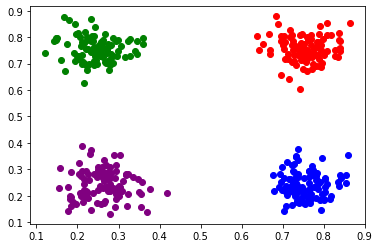

In [62]:
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] == 0:
        plt.scatter(data[i,0], data[i,1], c='blue');
    elif kmeans.labels_[i] == 1:
        plt.scatter(data[i,0], data[i,1], c='green');
    elif kmeans.labels_[i] == 2:
        plt.scatter(data[i,0], data[i,1], c='red');
    else:
        plt.scatter(data[i,0], data[i,1], c='purple');
plt.show();

Node 1 and 2


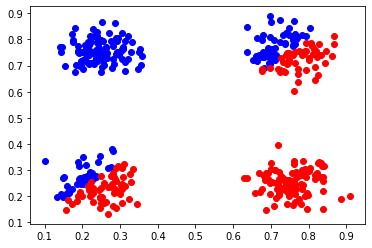

Node 3 and 4


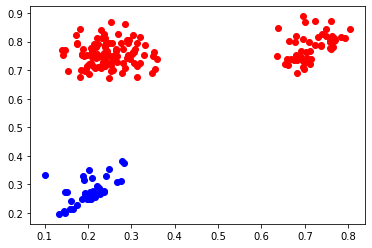

Node 5 and 6


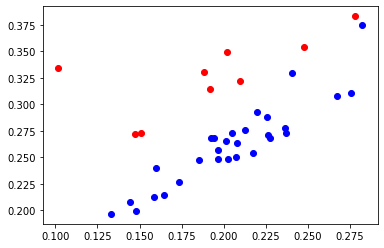

Node 7 and 8


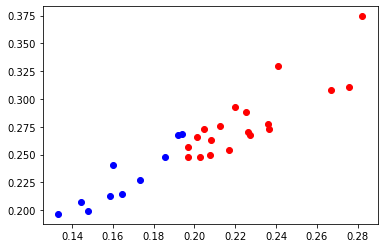

Node 9 and 10


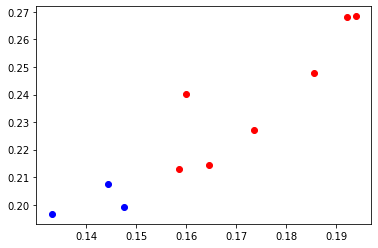

Node 11 and 12


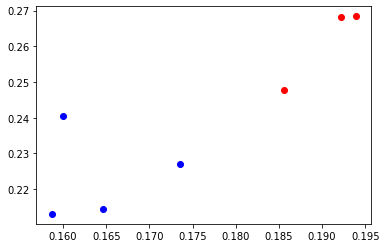

Node 13 and 14


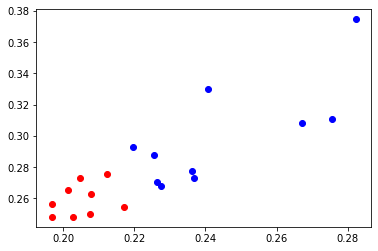

Node 15 and 16


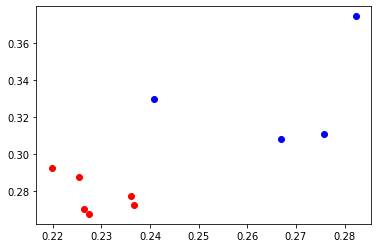

Node 17 and 18


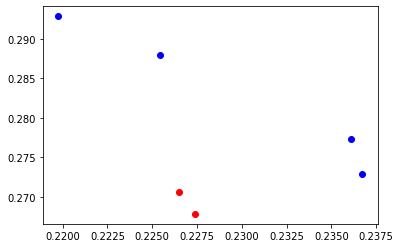

Node 19 and 20


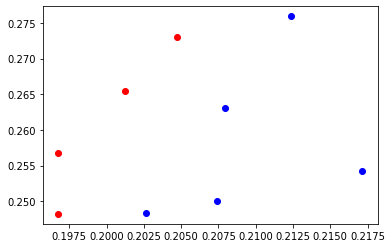

Node 21 and 22


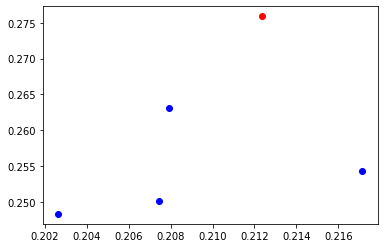

Node 23 and 24


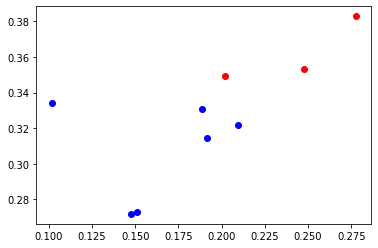

Node 25 and 26


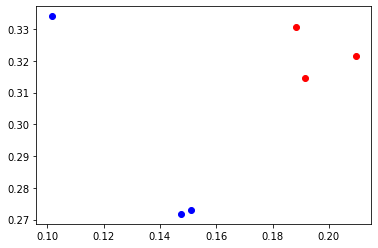

Node 27 and 28


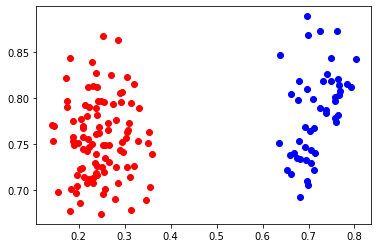

Node 29 and 30


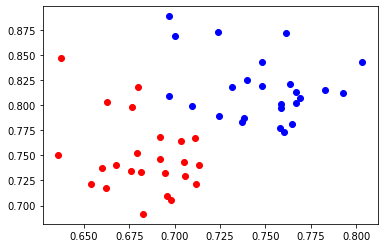

Node 31 and 32


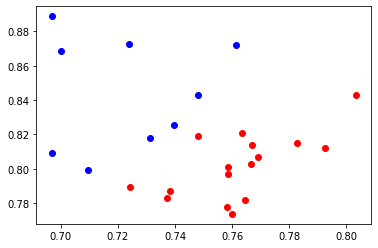

Node 33 and 34


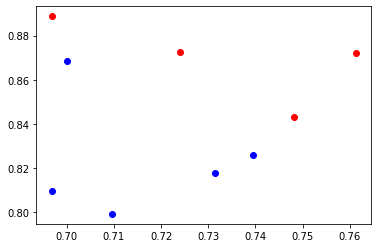

Node 35 and 36


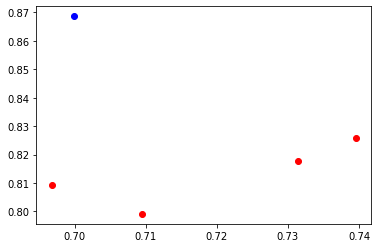

Node 37 and 38


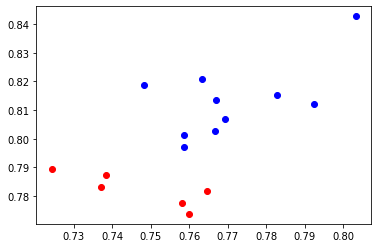

Node 39 and 40


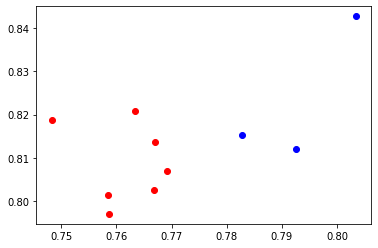

Node 41 and 42


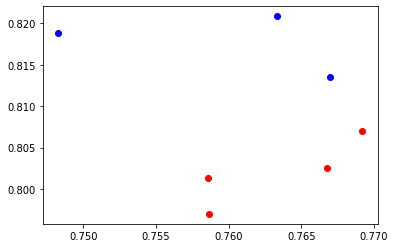

Node 43 and 44


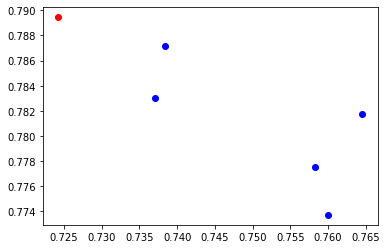

Node 45 and 46


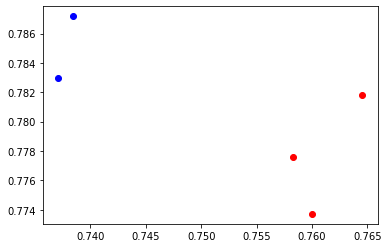

Node 47 and 48


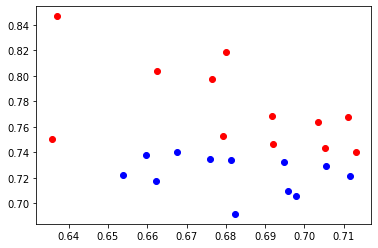

Node 49 and 50


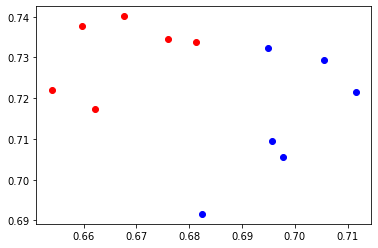

Node 51 and 52


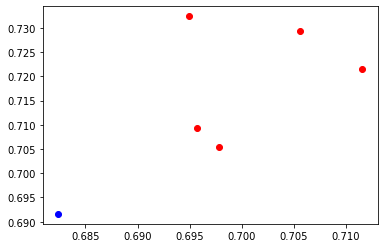

Node 53 and 54


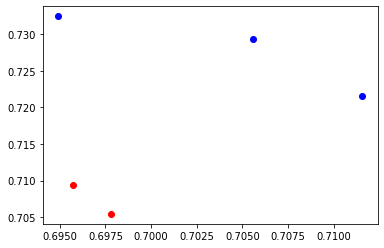

Node 55 and 56


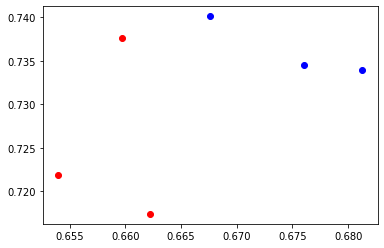

Node 57 and 58


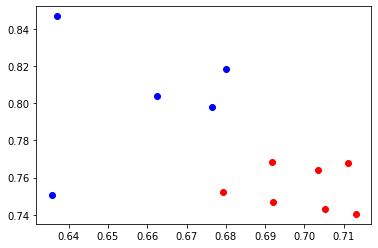

Node 59 and 60


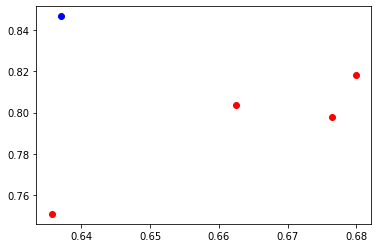

Node 61 and 62


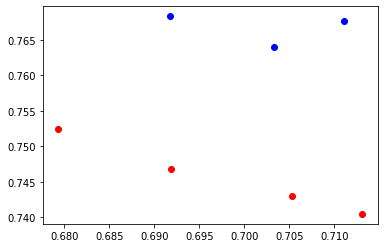

Node 63 and 64


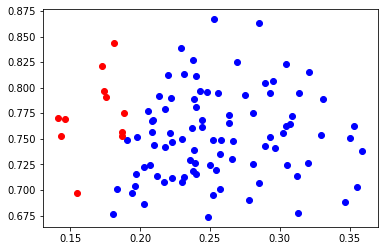

Node 65 and 66


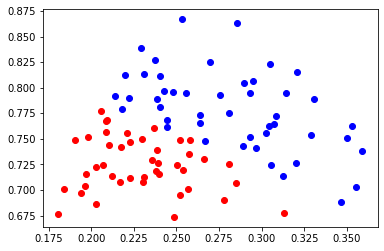

Node 67 and 68


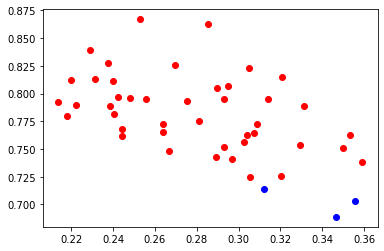

Node 69 and 70


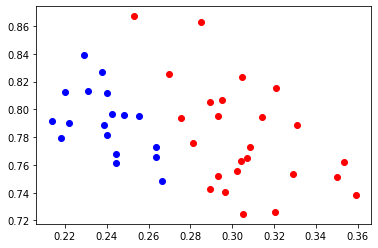

Node 71 and 72


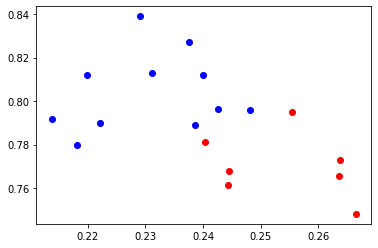

Node 73 and 74


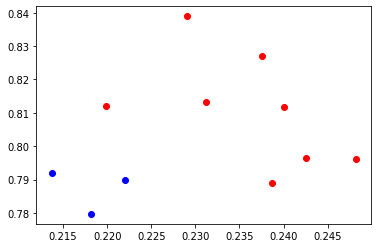

Node 75 and 76


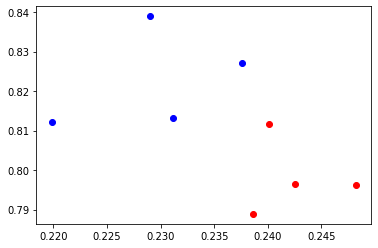

Node 77 and 78


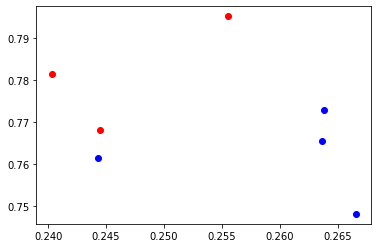

Node 79 and 80


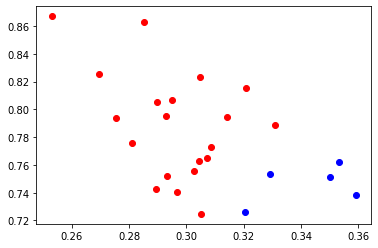

Node 81 and 82


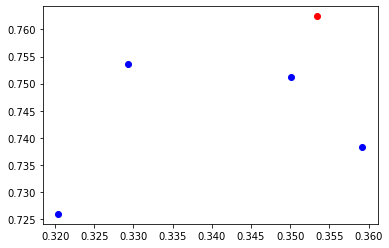

Node 83 and 84


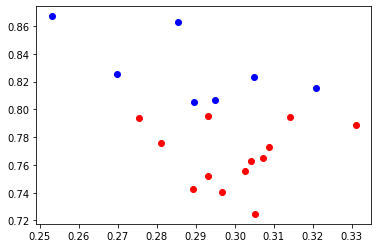

Node 85 and 86


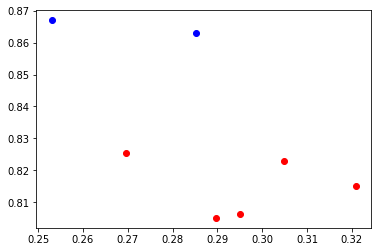

Node 87 and 88


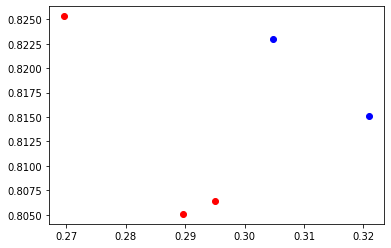

Node 89 and 90


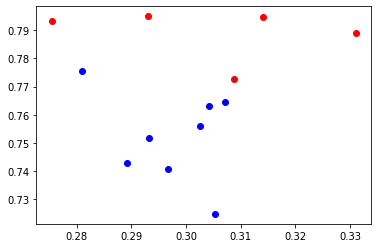

Node 91 and 92


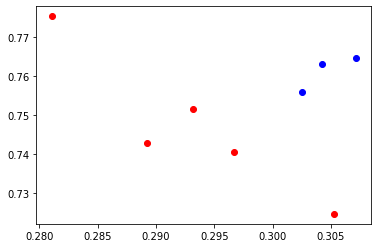

Node 93 and 94


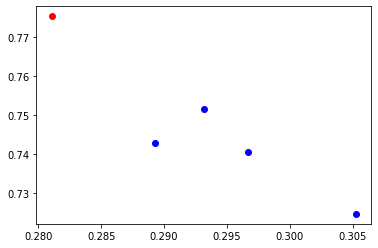

Node 95 and 96


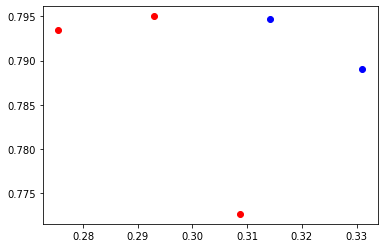

Node 97 and 98


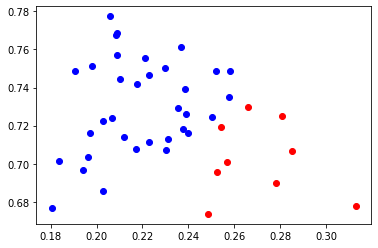

Node 99 and 100


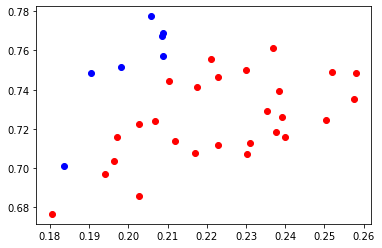

Node 101 and 102


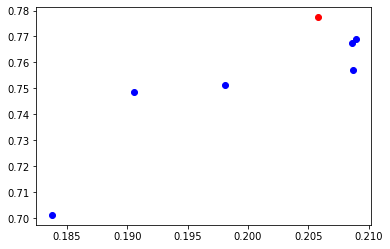

Node 103 and 104


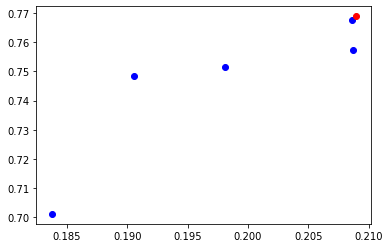

Node 105 and 106


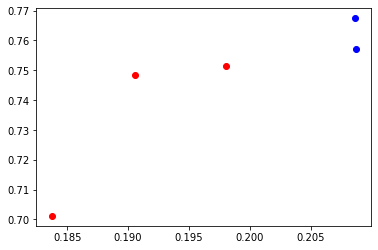

Node 107 and 108


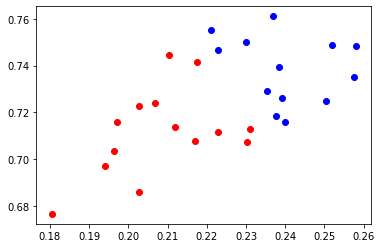

Node 109 and 110


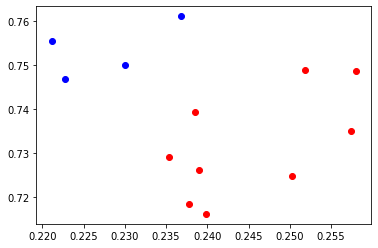

Node 111 and 112


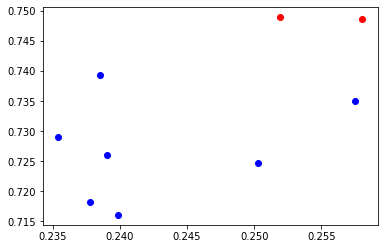

Node 113 and 114


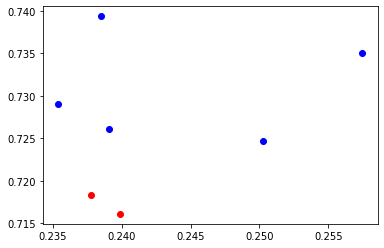

Node 115 and 116


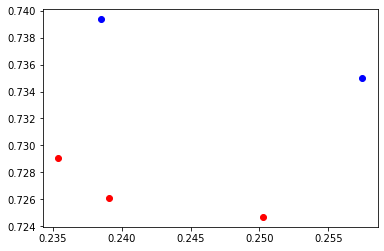

Node 117 and 118


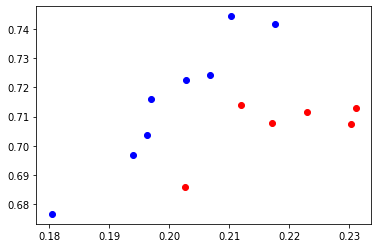

Node 119 and 120


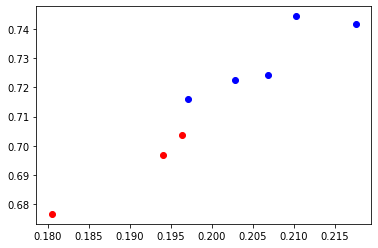

Node 121 and 122


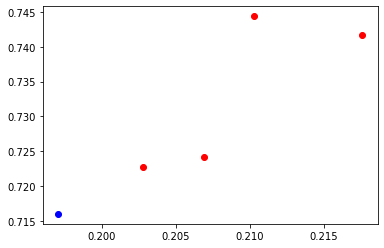

Node 123 and 124


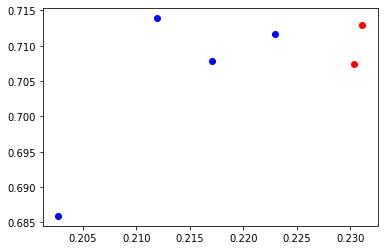

Node 125 and 126


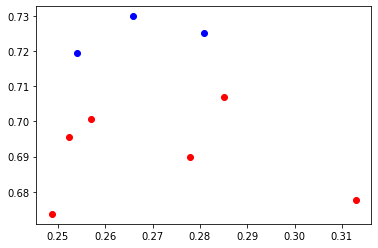

Node 127 and 128


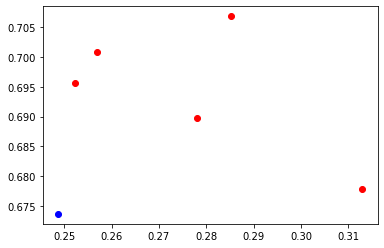

Node 129 and 130


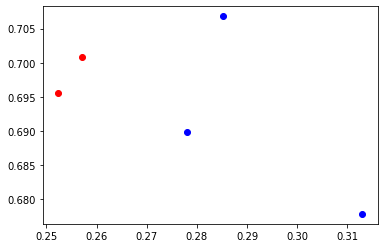

Node 131 and 132


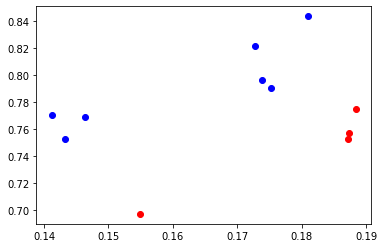

Node 133 and 134


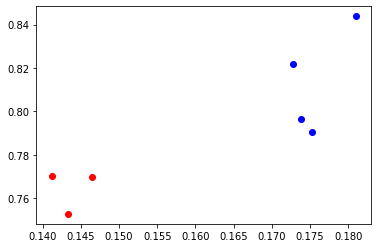

Node 135 and 136


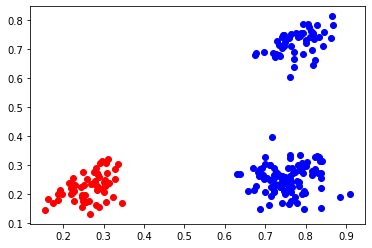

Node 137 and 138


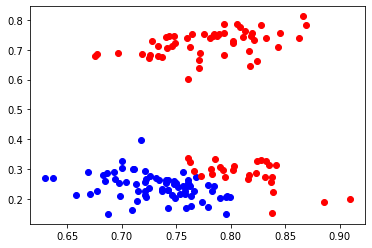

Node 139 and 140


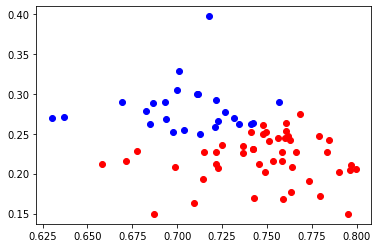

Node 141 and 142


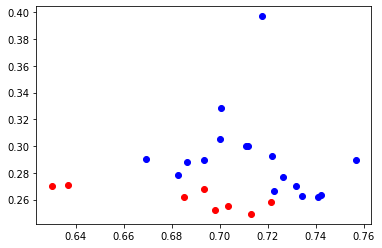

Node 143 and 144


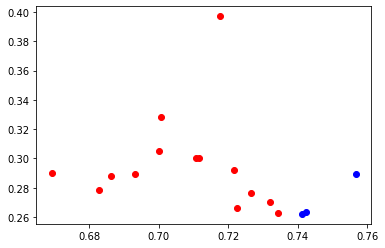

Node 145 and 146


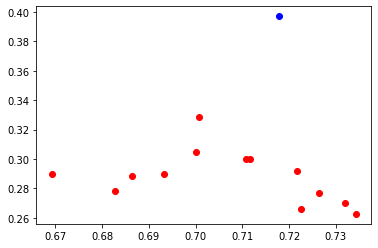

Node 147 and 148


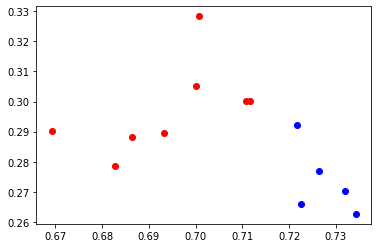

Node 149 and 150


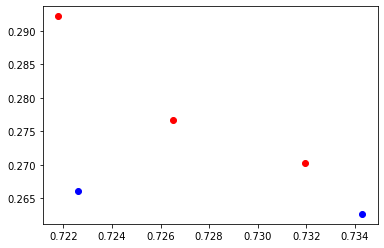

Node 151 and 152


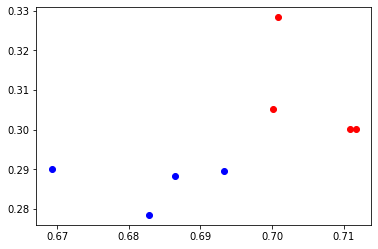

Node 153 and 154


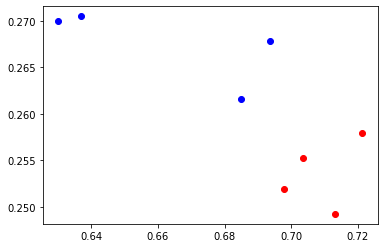

Node 155 and 156


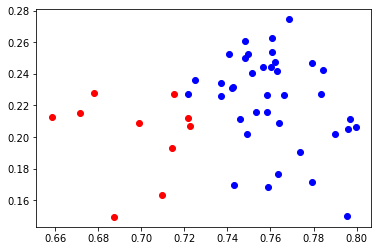

Node 157 and 158


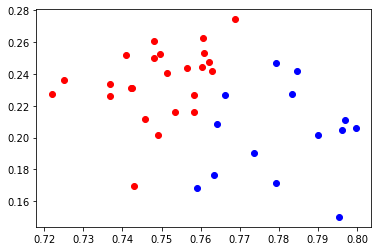

Node 159 and 160


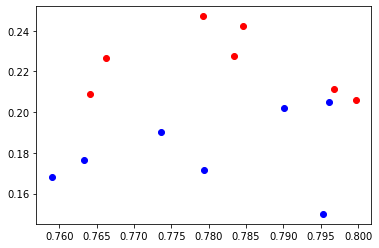

Node 161 and 162


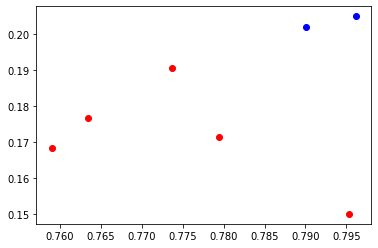

Node 163 and 164


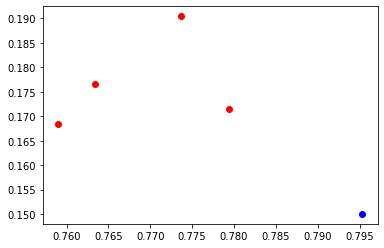

Node 165 and 166


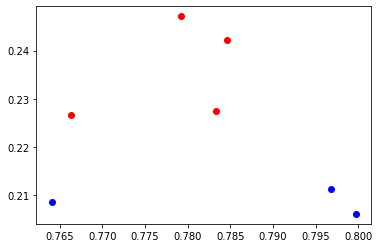

Node 167 and 168


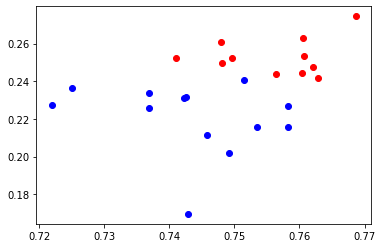

Node 169 and 170


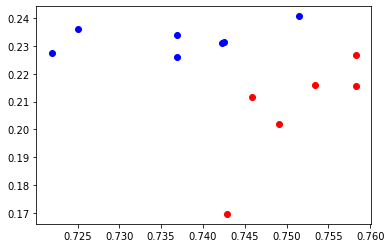

Node 171 and 172


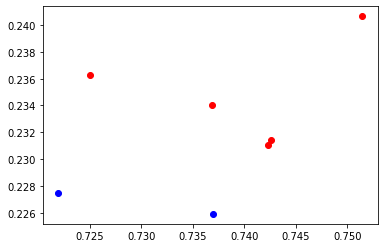

Node 173 and 174


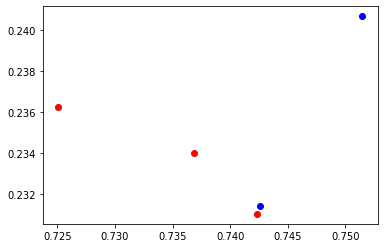

Node 175 and 176


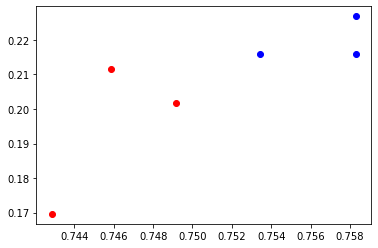

Node 177 and 178


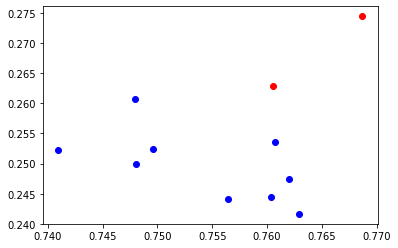

Node 179 and 180


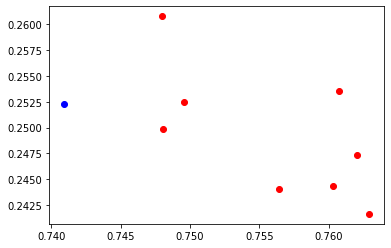

Node 181 and 182


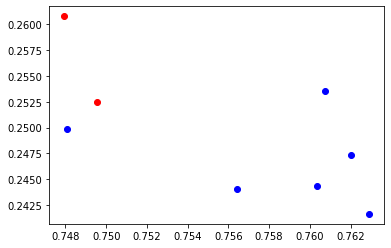

Node 183 and 184


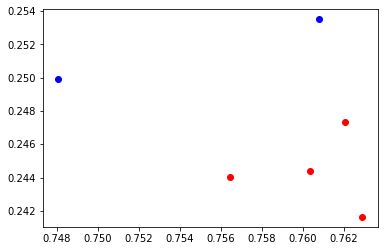

Node 185 and 186


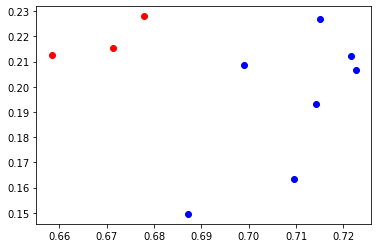

Node 187 and 188


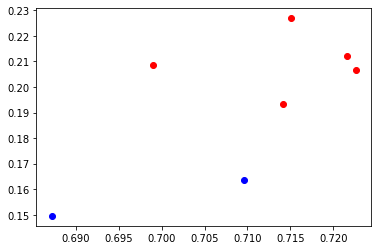

Node 189 and 190


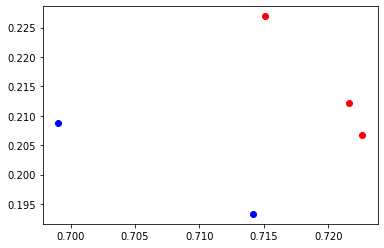

Node 191 and 192


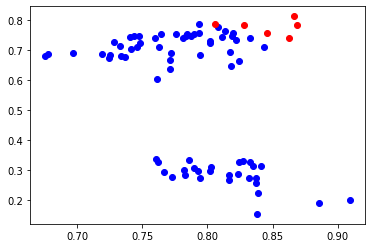

Node 193 and 194


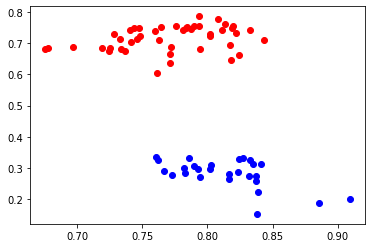

Node 195 and 196


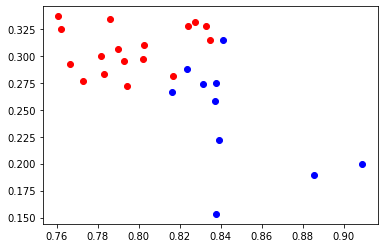

Node 197 and 198


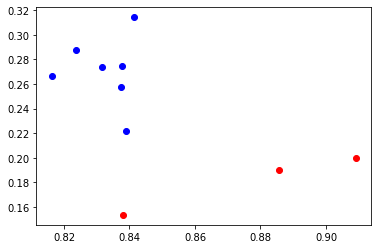

Node 199 and 200


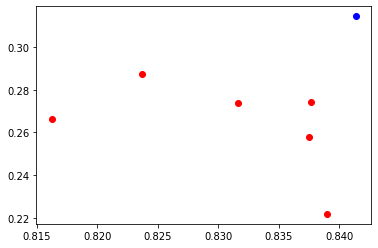

Node 201 and 202


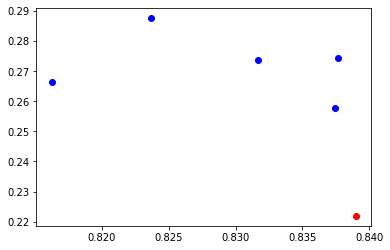

Node 203 and 204


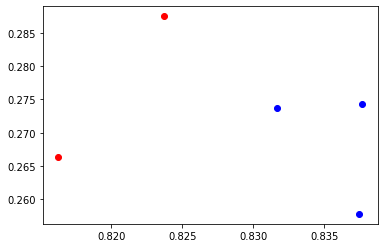

Node 205 and 206


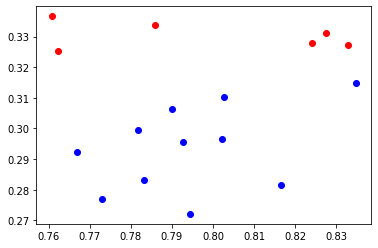

Node 207 and 208


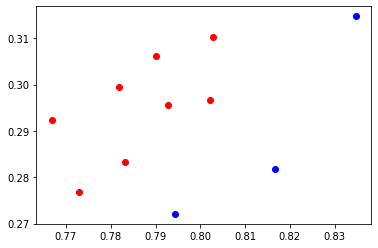

Node 209 and 210


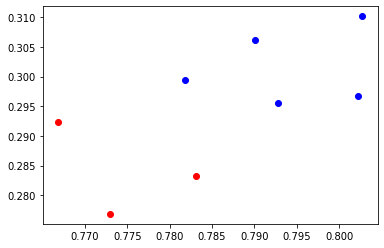

Node 211 and 212


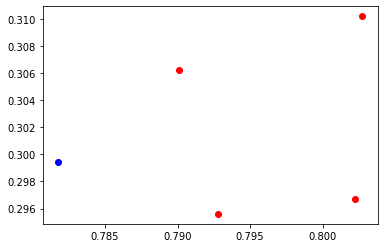

Node 213 and 214


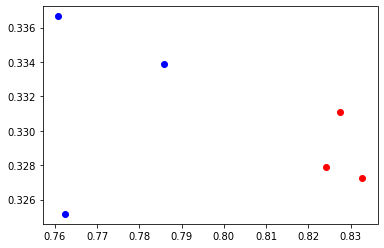

Node 215 and 216


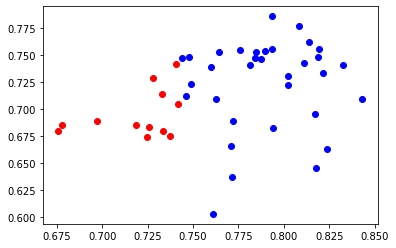

Node 217 and 218


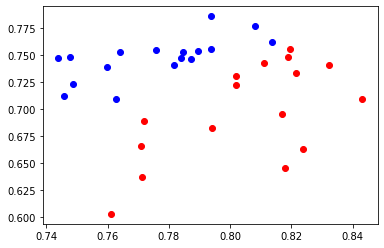

Node 219 and 220


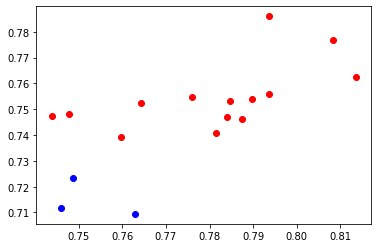

Node 221 and 222


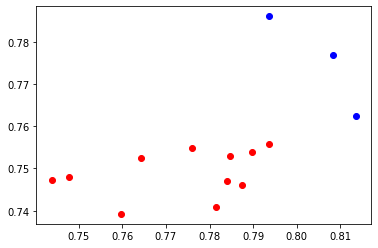

Node 223 and 224


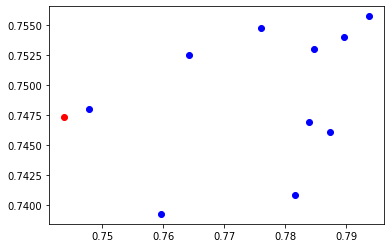

Node 225 and 226


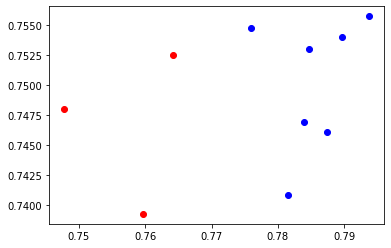

Node 227 and 228


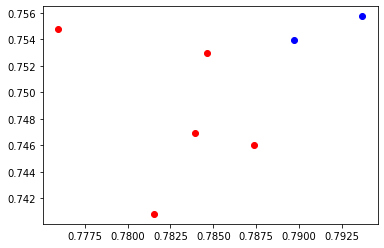

Node 229 and 230


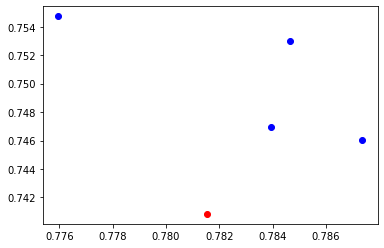

Node 231 and 232


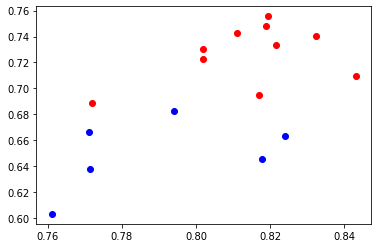

Node 233 and 234


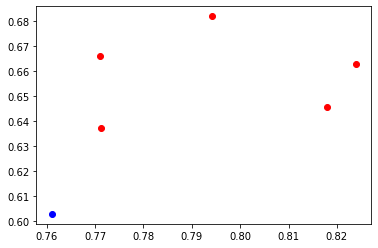

Node 235 and 236


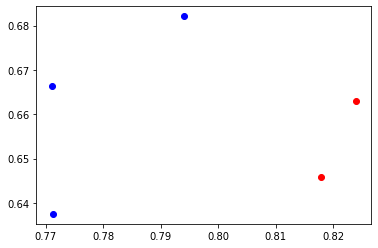

Node 237 and 238


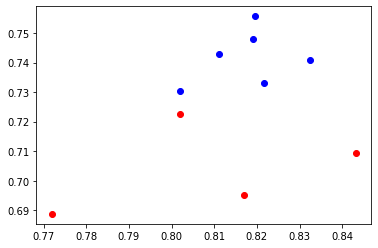

Node 239 and 240


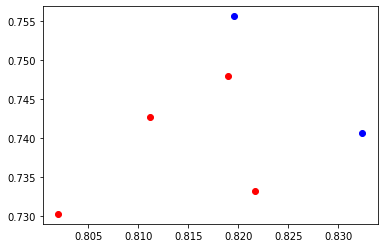

Node 241 and 242


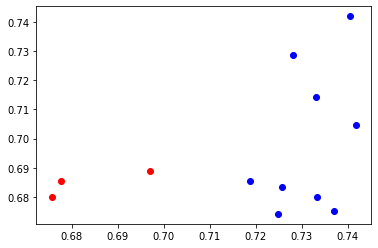

Node 243 and 244


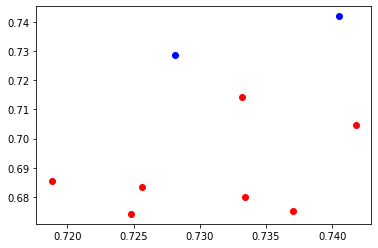

Node 245 and 246


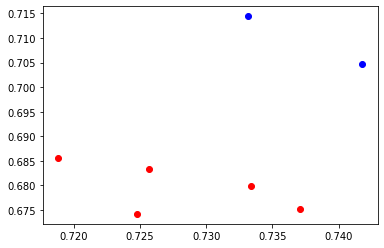

Node 247 and 248


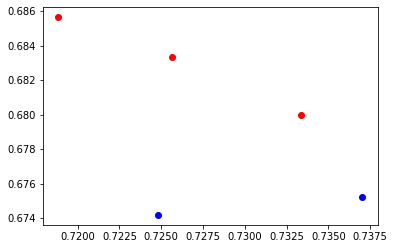

Node 249 and 250


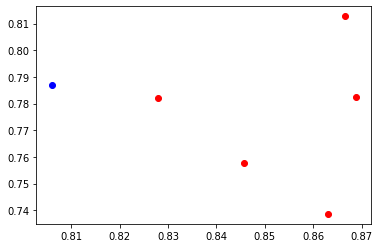

Node 251 and 252


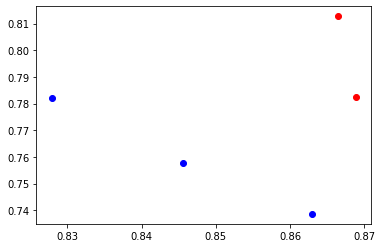

Node 253 and 254


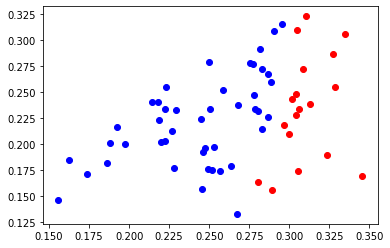

Node 255 and 256


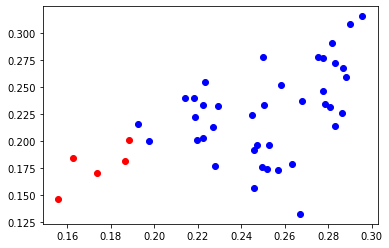

Node 257 and 258


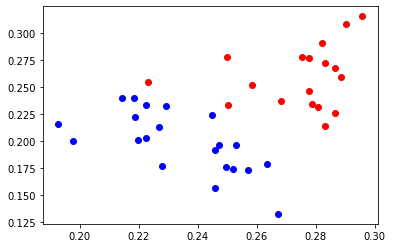

Node 259 and 260


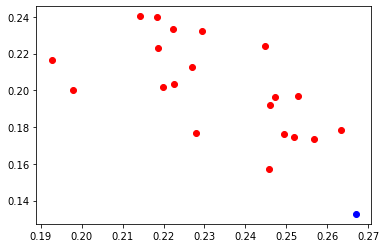

Node 261 and 262


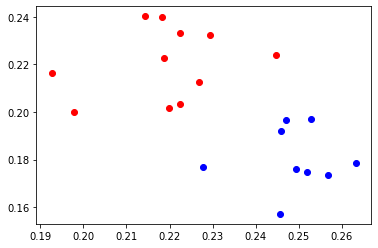

Node 263 and 264


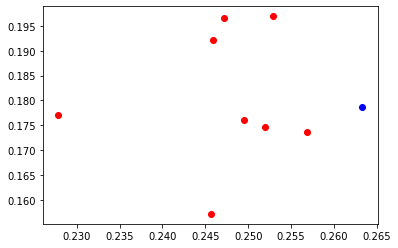

Node 265 and 266


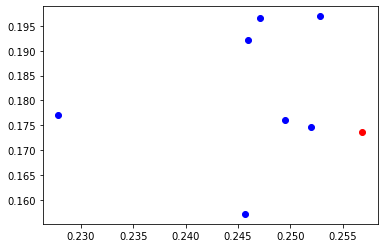

Node 267 and 268


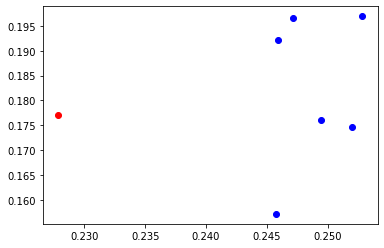

Node 269 and 270


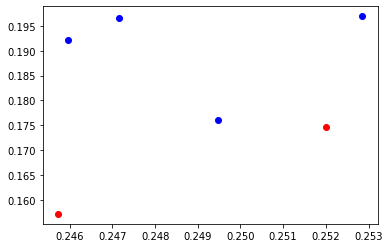

Node 271 and 272


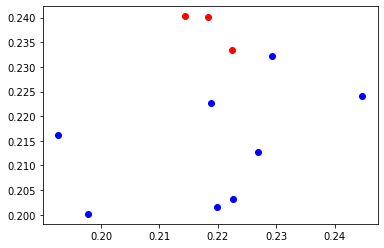

Node 273 and 274


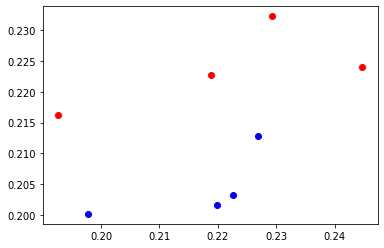

Node 275 and 276


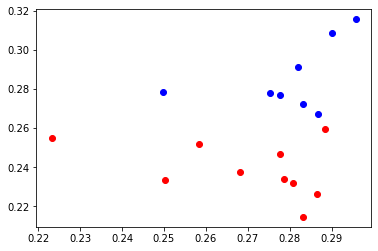

Node 277 and 278


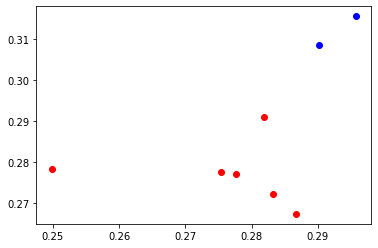

Node 279 and 280


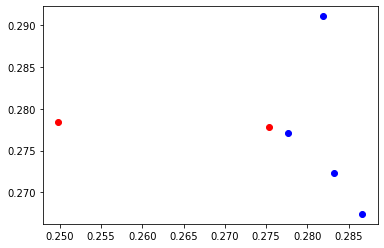

Node 281 and 282


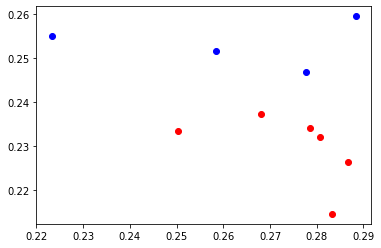

Node 283 and 284


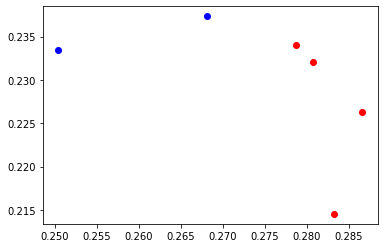

Node 285 and 286


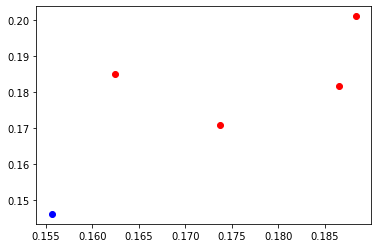

Node 287 and 288


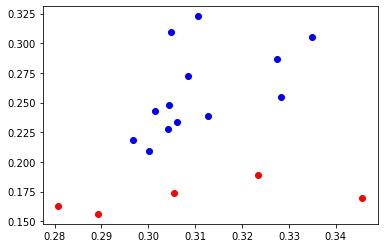

Node 289 and 290


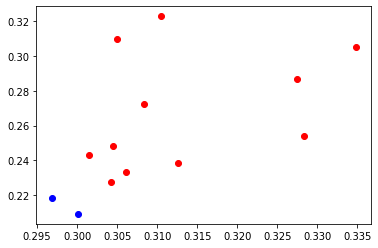

Node 291 and 292


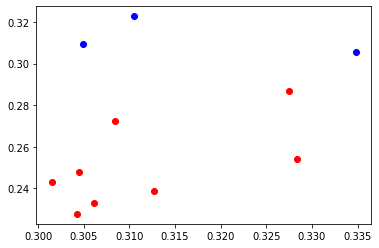

Node 293 and 294


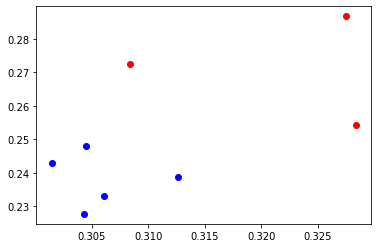

Node 295 and 296


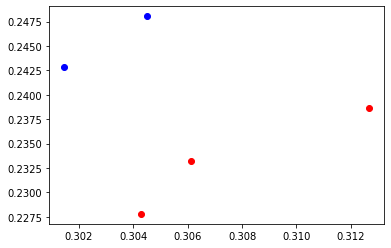

Node 297 and 298


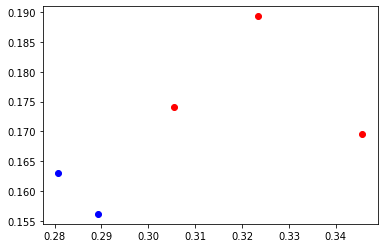

In [43]:
fsp = Fair_Split_Tree(data, k=4)
tree = fsp.build_tree()

In [50]:
wspd_pairs = WSPD(tree.root, tree.root, 2)

0.949697740184682
node  0 and node  0
0.8666719341414852
node  1 and node  0
switching u and v
0.8666719341414852
node  1 and node  1
0.055584158646102555
node  3 and node  1
switching u and v
0.055584158646102555
node  3 and node  3
0.05386406637110558
node  5 and node  3
switching u and v
0.05386406637110558
node  5 and node  5
0.008839920970775883
node  7 and node  5
switching u and v
0.008839920970775883
node  7 and node  7
0.0002457399615275568
node  9 and node  7
switching u and v
0.0002457399615275568
node  9 and node  9
0.004305047202236777
node  10 and node  9
found pair
0.004305047202236777
node  10 and node  7
switching u and v
0.0002457399615275568
node  9 and node  10
switching u and v
found pair
0.004305047202236777
node  10 and node  10
0.0007464685363066964
node  11 and node  10
switching u and v
0.0007464685363066964
node  11 and node  11
0.0004930391226318203
node  12 and node  11
switching u and v
found pair
0.0004930391226318203
node  12 and node  10
switching u and

In [66]:
type(wspd_pairs)

list

In [63]:
wspd_pairs[0]

(Node 86: [[0.30480541 0.82298235]
  [0.2696819  0.82531532]
  [0.32088703 0.81511977]
  [0.2896304  0.80507831]
  [0.29502442 0.80643375]],
 Node 85: [[0.25300587 0.8670215 ]
  [0.2853061  0.8630654 ]])

In [69]:
wspd_pairs[0][0].dataset[0]

array([0.30480541, 0.82298235])

In [71]:
new_wspd = []
for i in range(len(wspd_pairs)):
    add = True
    u = wspd_pairs[i][0]
    v = wspd_pairs[i][1]
    for p_u in range(u.dataset.shape[0]):
        for p_v in range(v.dataset.shape[0]):
            if kmeans.predict(u.dataset[p_u].reshape(1, -1)) == kmeans.predict(v.dataset[p_v].reshape(1, -1)):
                add = False
                break
            else:
                continue
        break
    if add:
        new_wspd.append(wspd_pairs[i])

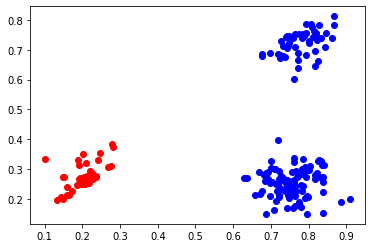

In [80]:
plt.scatter(new_wspd[0][0].dataset[:,0], new_wspd[0][0].dataset[:,1], c='blue');
plt.scatter(new_wspd[0][1].dataset[:,0], new_wspd[0][1].dataset[:,1], c='red');
plt.show()

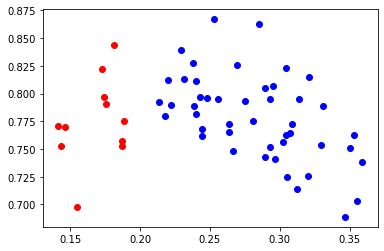

In [81]:
plt.scatter(wspd_pairs[0][0].dataset[:,0], wspd_pairs[0][0].dataset[:,1], c='blue');
plt.scatter(wspd_pairs[0][1].dataset[:,0], wspd_pairs[0][1].dataset[:,1], c='red');
plt.show()